In [1]:
from skimage import feature
from functools import partial
from PIL import Image
import numpy as np
import cv2 as cv
import pandas as pd
import h5py
import os
import matplotlib.pyplot as plt
import seaborn as sns

from cv_anomaly_detection.utils import MVTEC_AD, DATA_DIR
from cv_anomaly_detection.img_dataframe import ImageDataFrameMVTEC
from cv_anomaly_detection.metrics.img_metrics import measure_brightness
from cv_anomaly_detection.utils.plots import show, show_list_of_images
from cv_anomaly_detection.utils.plots import plot_multiscale_basic_features, plot_pca_cumulative_variance
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA

%load_ext autoreload
%autoreload 2

# Features

for this part we will use the multiscale_basic_features from scikit-image from the article:  [Trainable segmentation using local features and random forests](https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_trainable_segmentation.html)

In [2]:
sigma_min = 1
sigma_max = 16
features_func = partial(feature.multiscale_basic_features,
                        intensity=True, edges=True, texture=True,
                        sigma_min=sigma_min, sigma_max=sigma_max,
                        channel_axis=-1, num_sigma=1)

# due to RAM limitations we will use a smaller size image
IMAGE_SIZE = (256, 256)
# Original image size is the one below
# IMAGE_SIZE = (1024, 1024)

In [3]:
img_df = ImageDataFrameMVTEC(category="cable")
img_df.init_default()
img_df.df

['cut_outer_insulation', 'cut_inner_insulation', 'combined', 'poke_insulation', 'good', 'missing_wire', 'missing_cable', 'cable_swap', 'bent_wire']


,image_path,width,height,dataset_type,class
0,/home/marcelo/github.com/cv-anomaly-detection/...,1024,1024,train,good
1,/home/marcelo/github.com/cv-anomaly-detection/...,1024,1024,train,good
2,/home/marcelo/github.com/cv-anomaly-detection/...,1024,1024,train,good
3,/home/marcelo/github.com/cv-anomaly-detection/...,1024,1024,train,good
4,/home/marcelo/github.com/cv-anomaly-detection/...,1024,1024,train,good
...,...,...,...,...,...
369,/home/marcelo/github.com/cv-anomaly-detection/...,1024,1024,test,bent_wire
370,/home/marcelo/github.com/cv-anomaly-detection/...,1024,1024,test,bent_wire
371,/home/marcelo/github.com/cv-anomaly-detection/...,1024,1024,test,bent_wire
372,/home/marcelo/github.com/cv-anomaly-detection/...,1024,1024,test,bent_wire


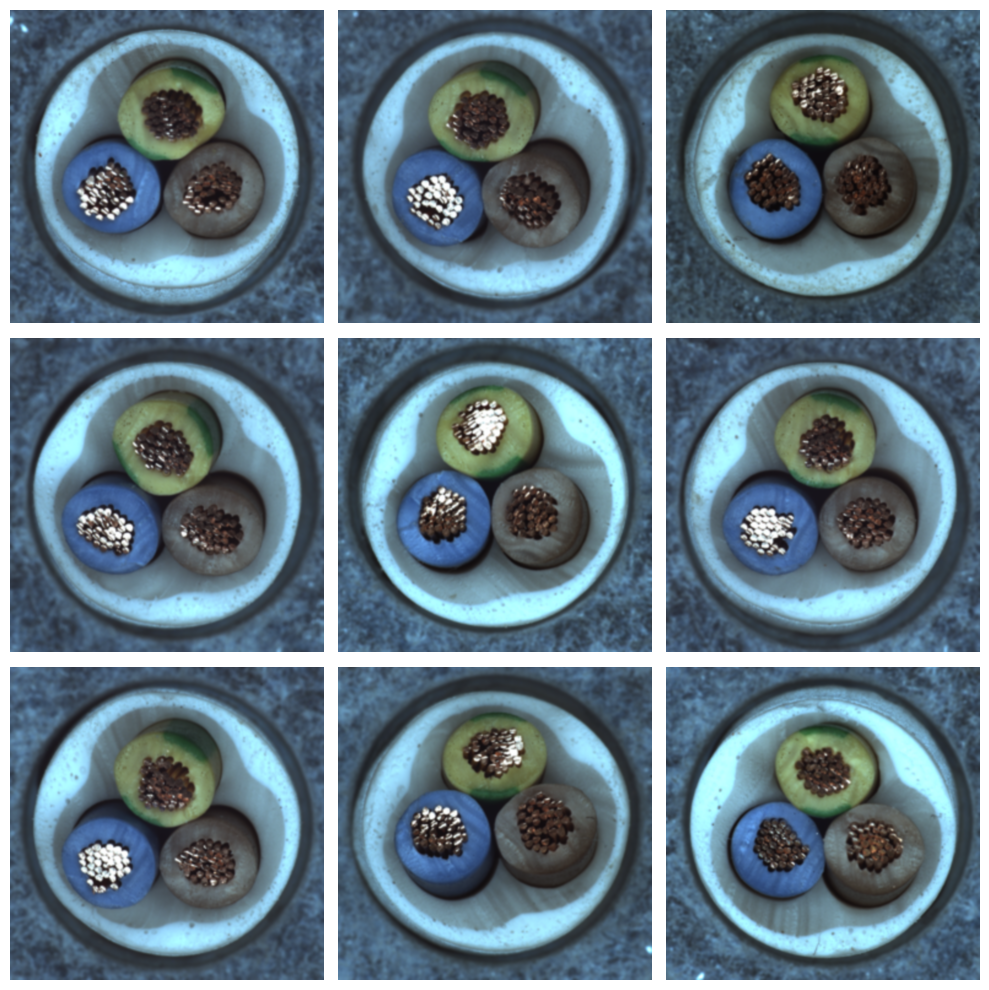

In [4]:
test_df = img_df.df[img_df.df["dataset_type"] == "test"]
test_sample = test_df[test_df["class"] == "good"].sample(n=9, replace=False)
img_arr = [Image.open(path).resize(IMAGE_SIZE) for path in test_sample["image_path"]]

show_list_of_images(img_arr)

In [5]:
#convert image array to numpy array
img_arr = [np.array(img) for img in img_arr]
img_0_feats = features_func(img_arr[0])

In [6]:
img_0_feats.shape

(256, 256, 12)

# Visualizing the features from scikit-image multiscale_basic_features

the plot below shows the features for the first image from the example array, using features like intensity, edges and texture

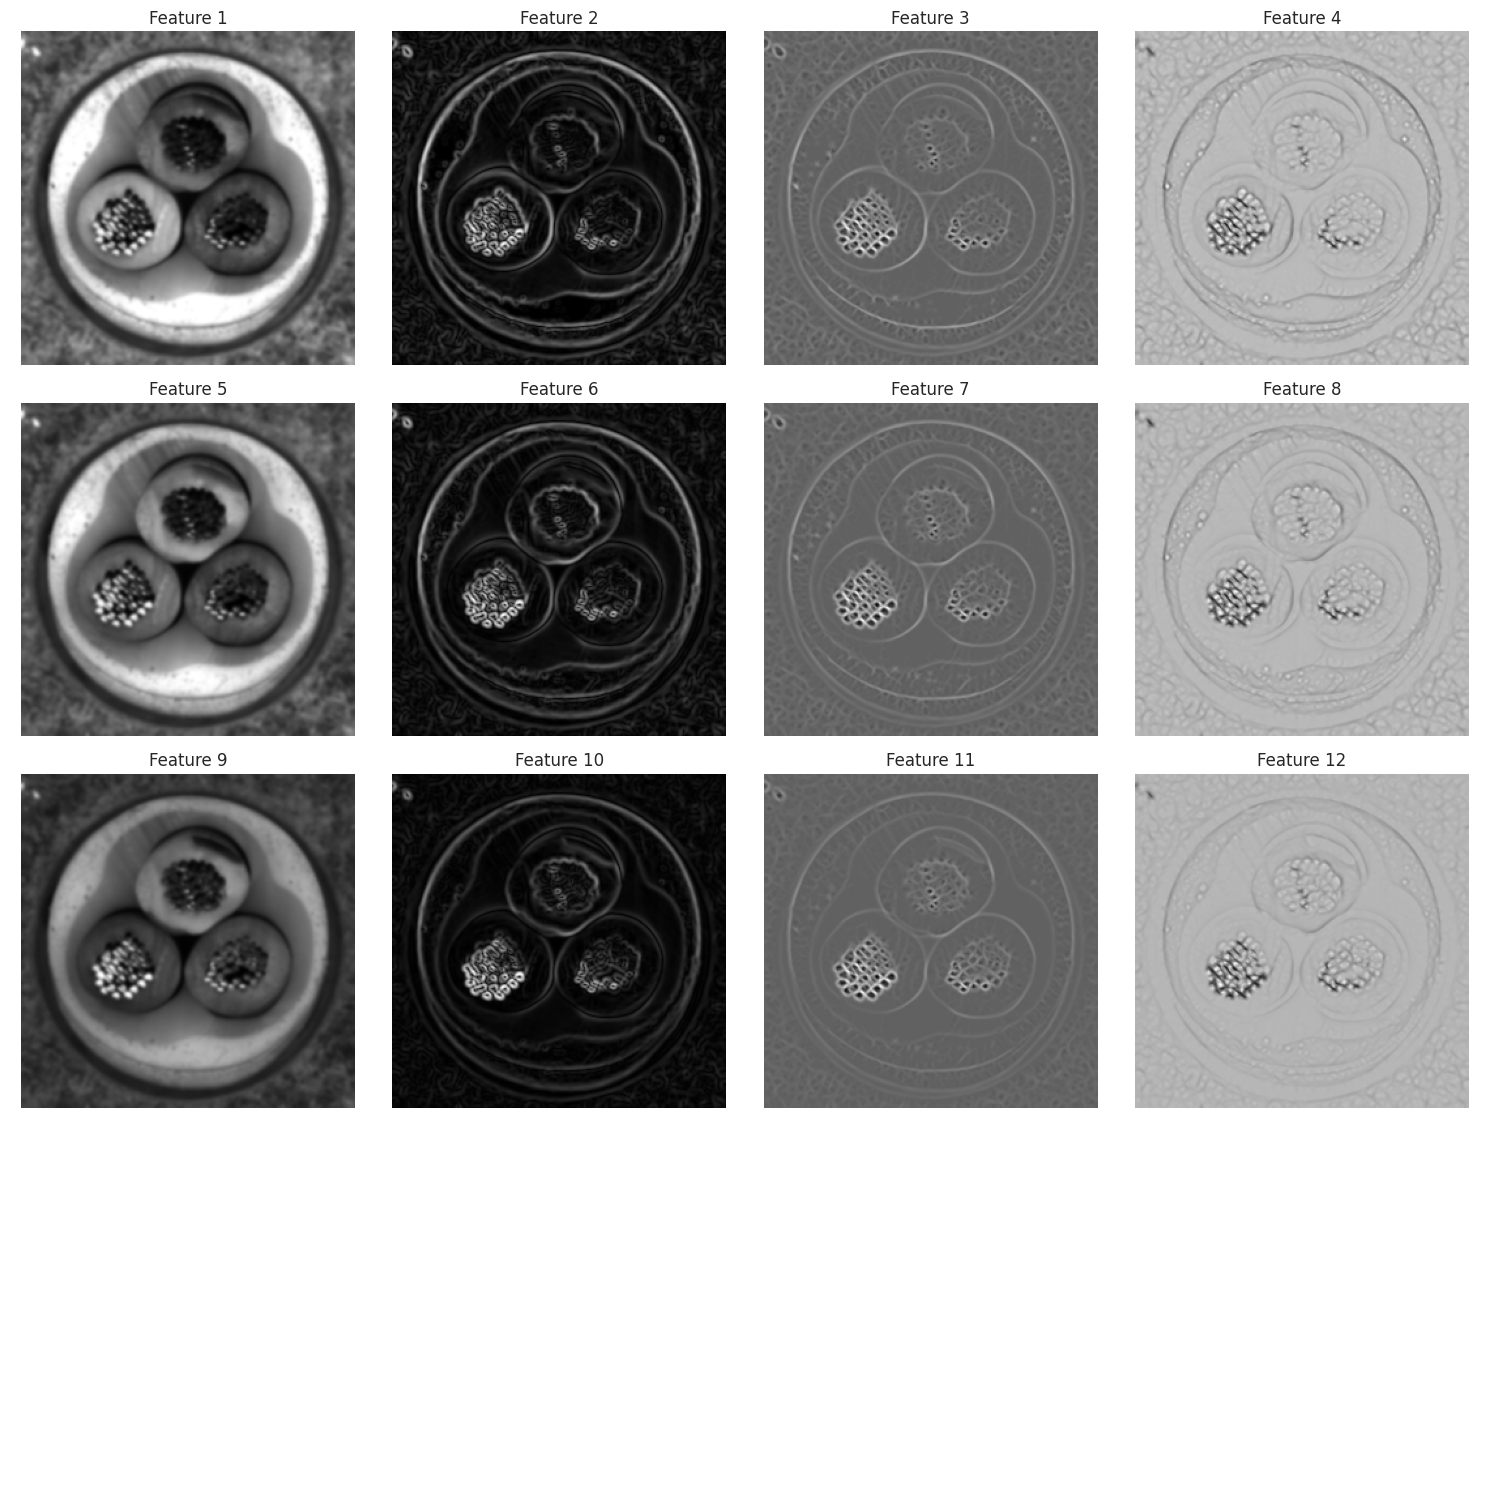

In [7]:
plot_multiscale_basic_features(img_arr[0], features_func)

# Limitations due to RAM

The step below needed did not fit in RAM, some attempts could be made for example generate a csv file with the features in disk and work from it and use incremental PCA, I used HDF5 for saving on disk and using incremental PCA with batch size of 32. One possible usage would be resize of the images and then use the multiscale_basic_features from scikit-image.

Based on Stack overflow [Incremental PCA on big data](https://stackoverflow.com/questions/31428581/incremental-pca-on-big-data) question I used the following steps:

 - I resized the samples to 256x256
 - I used incremental PCA
 - I used HDF5 to save on disk
 - I used batch size of 32

with this I could reduce the ram required from the memory leak in my 32 GB pc to less than 8GB of memory usage in htop

In [8]:
# metrics = (
#     ("multiscale_basic_features", lambda path: features_func(cv.resize(cv.imread(path), IMAGE_SIZE)).flatten().tolist()),
# )
# img_df.apply_metrics(metrics) 

with h5py.File(os.path.join(DATA_DIR, 'tmp.h5'), 'w') as h5:
    flattened_feats = img_0_feats.flatten()
    
    train_df = img_df.df[img_df.df["dataset_type"] == "train"]
    rows, _ = train_df.shape
    h5.create_dataset('data', shape=(rows, flattened_feats.shape[0]), dtype=flattened_feats.dtype)
    
    for i in range(rows):
        path = train_df.iloc[i]["image_path"]
        h5["data"][i, :] = features_func(cv.resize(cv.imread(path), dsize=IMAGE_SIZE)).flatten()


In [9]:
chunk_size = 1 # how many rows we feed to IPCA at a time, the divisor of n
min_val = np.inf
max_val = -np.inf

# the below code was used when I was using original sized image and it could not fit in memory, so I had to use incremental PCA

# with h5py.File(os.path.join(DATA_DIR, 'tmp.h5'), 'r') as h5:
#     data = h5["data"]
#     
#     n = data.shape[0] # how many rows we have in the dataset
#     pca = IncrementalPCA(batch_size=chunk_size)
# 
#     for i in range(0, n // chunk_size, chunk_size):
#         chunk = data[i*chunk_size : (i+1)*chunk_size]  # Load the chunk into memory
#         min_val = min(np.min(chunk), min_val)  # Update the minimum value
#         max_val = max(np.max(chunk), max_val)
#         pca.partial_fit(chunk)


In [10]:
with h5py.File(os.path.join(DATA_DIR, 'tmp.h5'), 'r') as h5:
    data = h5["data"]
    pca = PCA()
    pca.fit_transform(data)
    min_val = min(np.min(data), min_val)  # Update the minimum value
    max_val = max(np.max(data), max_val)
    
print(f"Minimum value: {min_val}, Maximum value: {max_val}")

Minimum value: -0.26178669929504395, Maximum value: 1.0


# Checking the components from IncrementalPCA

In [11]:
print(pca.components_)

[[ 3.6293617e-04  8.3536055e-05 -3.5110781e-05 ...  8.6699383e-06
   3.5342826e-05  3.8414728e-07]
 [ 3.9102091e-04 -1.7057826e-05  4.5906512e-05 ...  3.8228038e-05
   8.6132732e-06 -2.2936300e-05]
 [ 8.3722884e-04  9.1735623e-05 -1.2995646e-05 ...  1.4898692e-04
   1.0980932e-05 -4.3454744e-05]
 ...
 [-3.5691480e-03 -3.5930425e-05  2.7807179e-04 ... -2.9289242e-04
  -4.4768647e-04 -1.6962529e-04]
 [ 4.9222412e-04  7.8219996e-04 -1.1372640e-04 ...  1.2822256e-04
  -2.1748200e-04 -1.2700255e-04]
 [ 2.0195980e-02  1.1862823e-02 -3.0714969e-04 ...  1.0733322e-05
  -1.0669931e-06  1.0591759e-06]]


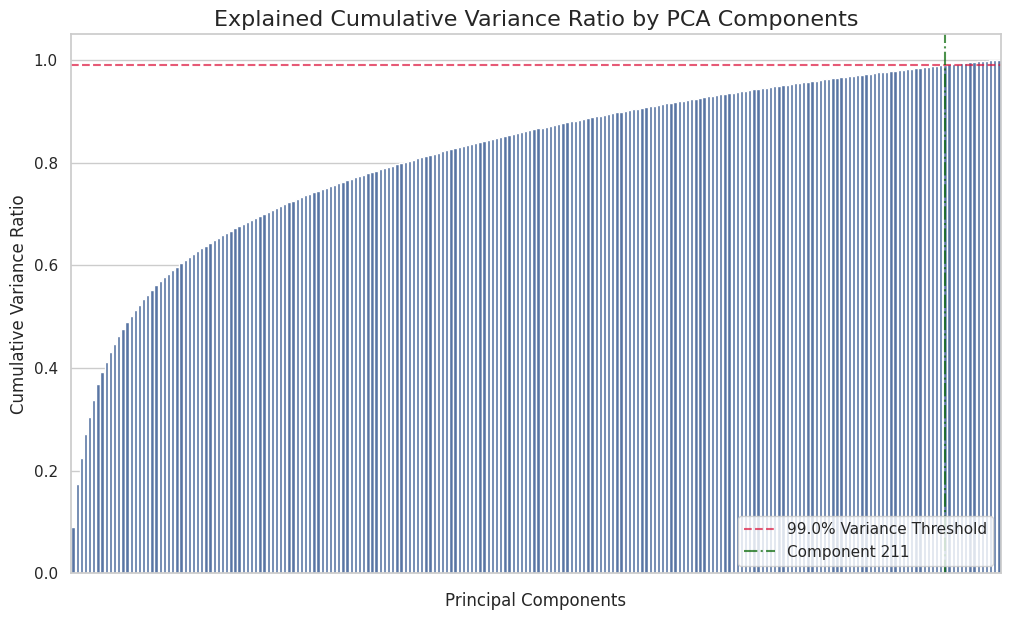

In [12]:
plot_pca_cumulative_variance(pca, threshold=0.99, remove_x_ticks=True)